In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/forecasting-sticker-sales/sample_submission.csv
/kaggle/input/forecasting-sticker-sales/train.csv
/kaggle/input/forecasting-sticker-sales/test.csv


# 01 / 20 / 2025
# TODO: Cross validation and using Mean Absolute Percentage Error

In [2]:
sticker_data = pd.read_csv('/kaggle/input/forecasting-sticker-sales/train.csv')
sticker_data.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [3]:
sticker_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


#Because we are trying to predict the number sold, we cannot impute that data as it may interfere with our final results, so we'll drop all rows that have no num_sold data

In [4]:
sticker_data_cleaned = sticker_data[sticker_data['num_sold'].notna()]
sticker_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221259 entries, 1 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        221259 non-null  int64  
 1   date      221259 non-null  object 
 2   country   221259 non-null  object 
 3   store     221259 non-null  object 
 4   product   221259 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 11.8+ MB


In [5]:
sticker_data['country'].unique()

array(['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore'],
      dtype=object)

In [6]:
sticker_data['store'].unique()

array(['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'],
      dtype=object)

In [7]:
sticker_data['product'].unique()

array(['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler',
       'Kerneler Dark Mode'], dtype=object)

In [8]:
# Checking to see if there's any order among the different cards sold
sticker_data['product'].value_counts()

product
Holographic Goose     46026
Kaggle                46026
Kaggle Tiers          46026
Kerneler              46026
Kerneler Dark Mode    46026
Name: count, dtype: int64

Except for date, all features should be one-hot encoded and because we are predicting a continous variable with a large dataset ( > 100k), we will use the SGDRegressor.
We will drop id and date.

In [9]:
# See if our join was correct
df = sticker_data_cleaned.join(pd.get_dummies(sticker_data_cleaned['country'])).drop(columns='country')
df

,id,date,store,product,num_sold,Canada,Finland,Italy,Kenya,Norway,Singapore
1,1,2010-01-01,Discount Stickers,Kaggle,973.0,True,False,False,False,False,False
2,2,2010-01-01,Discount Stickers,Kaggle Tiers,906.0,True,False,False,False,False,False
3,3,2010-01-01,Discount Stickers,Kerneler,423.0,True,False,False,False,False,False
4,4,2010-01-01,Discount Stickers,Kerneler Dark Mode,491.0,True,False,False,False,False,False
5,5,2010-01-01,Stickers for Less,Holographic Goose,300.0,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,2016-12-31,Premium Sticker Mart,Holographic Goose,466.0,False,False,False,False,False,True
230126,230126,2016-12-31,Premium Sticker Mart,Kaggle,2907.0,False,False,False,False,False,True
230127,230127,2016-12-31,Premium Sticker Mart,Kaggle Tiers,2299.0,False,False,False,False,False,True
230128,230128,2016-12-31,Premium Sticker Mart,Kerneler,1242.0,False,False,False,False,False,True


In [10]:
sticker_data_cleaned = df
sticker_data_cleaned

,id,date,store,product,num_sold,Canada,Finland,Italy,Kenya,Norway,Singapore
1,1,2010-01-01,Discount Stickers,Kaggle,973.0,True,False,False,False,False,False
2,2,2010-01-01,Discount Stickers,Kaggle Tiers,906.0,True,False,False,False,False,False
3,3,2010-01-01,Discount Stickers,Kerneler,423.0,True,False,False,False,False,False
4,4,2010-01-01,Discount Stickers,Kerneler Dark Mode,491.0,True,False,False,False,False,False
5,5,2010-01-01,Stickers for Less,Holographic Goose,300.0,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,2016-12-31,Premium Sticker Mart,Holographic Goose,466.0,False,False,False,False,False,True
230126,230126,2016-12-31,Premium Sticker Mart,Kaggle,2907.0,False,False,False,False,False,True
230127,230127,2016-12-31,Premium Sticker Mart,Kaggle Tiers,2299.0,False,False,False,False,False,True
230128,230128,2016-12-31,Premium Sticker Mart,Kerneler,1242.0,False,False,False,False,False,True


In [11]:
df = sticker_data_cleaned.join(pd.get_dummies(sticker_data_cleaned['store'])).drop(columns='store')
df

,id,date,product,num_sold,Canada,Finland,Italy,Kenya,Norway,Singapore,Discount Stickers,Premium Sticker Mart,Stickers for Less
1,1,2010-01-01,Kaggle,973.0,True,False,False,False,False,False,True,False,False
2,2,2010-01-01,Kaggle Tiers,906.0,True,False,False,False,False,False,True,False,False
3,3,2010-01-01,Kerneler,423.0,True,False,False,False,False,False,True,False,False
4,4,2010-01-01,Kerneler Dark Mode,491.0,True,False,False,False,False,False,True,False,False
5,5,2010-01-01,Holographic Goose,300.0,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,2016-12-31,Holographic Goose,466.0,False,False,False,False,False,True,False,True,False
230126,230126,2016-12-31,Kaggle,2907.0,False,False,False,False,False,True,False,True,False
230127,230127,2016-12-31,Kaggle Tiers,2299.0,False,False,False,False,False,True,False,True,False
230128,230128,2016-12-31,Kerneler,1242.0,False,False,False,False,False,True,False,True,False


In [12]:
sticker_data_cleaned = df
sticker_data_cleaned

,id,date,product,num_sold,Canada,Finland,Italy,Kenya,Norway,Singapore,Discount Stickers,Premium Sticker Mart,Stickers for Less
1,1,2010-01-01,Kaggle,973.0,True,False,False,False,False,False,True,False,False
2,2,2010-01-01,Kaggle Tiers,906.0,True,False,False,False,False,False,True,False,False
3,3,2010-01-01,Kerneler,423.0,True,False,False,False,False,False,True,False,False
4,4,2010-01-01,Kerneler Dark Mode,491.0,True,False,False,False,False,False,True,False,False
5,5,2010-01-01,Holographic Goose,300.0,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,2016-12-31,Holographic Goose,466.0,False,False,False,False,False,True,False,True,False
230126,230126,2016-12-31,Kaggle,2907.0,False,False,False,False,False,True,False,True,False
230127,230127,2016-12-31,Kaggle Tiers,2299.0,False,False,False,False,False,True,False,True,False
230128,230128,2016-12-31,Kerneler,1242.0,False,False,False,False,False,True,False,True,False


In [13]:
df = sticker_data_cleaned.join(pd.get_dummies(sticker_data_cleaned['product'])).drop(columns='product')
df

,id,date,num_sold,Canada,Finland,Italy,Kenya,Norway,Singapore,Discount Stickers,Premium Sticker Mart,Stickers for Less,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode
1,1,2010-01-01,973.0,True,False,False,False,False,False,True,False,False,False,True,False,False,False
2,2,2010-01-01,906.0,True,False,False,False,False,False,True,False,False,False,False,True,False,False
3,3,2010-01-01,423.0,True,False,False,False,False,False,True,False,False,False,False,False,True,False
4,4,2010-01-01,491.0,True,False,False,False,False,False,True,False,False,False,False,False,False,True
5,5,2010-01-01,300.0,True,False,False,False,False,False,False,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,2016-12-31,466.0,False,False,False,False,False,True,False,True,False,True,False,False,False,False
230126,230126,2016-12-31,2907.0,False,False,False,False,False,True,False,True,False,False,True,False,False,False
230127,230127,2016-12-31,2299.0,False,False,False,False,False,True,False,True,False,False,False,True,False,False
230128,230128,2016-12-31,1242.0,False,False,False,False,False,True,False,True,False,False,False,False,True,False


In [14]:
sticker_data_cleaned = df
sticker_data_cleaned

,id,date,num_sold,Canada,Finland,Italy,Kenya,Norway,Singapore,Discount Stickers,Premium Sticker Mart,Stickers for Less,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode
1,1,2010-01-01,973.0,True,False,False,False,False,False,True,False,False,False,True,False,False,False
2,2,2010-01-01,906.0,True,False,False,False,False,False,True,False,False,False,False,True,False,False
3,3,2010-01-01,423.0,True,False,False,False,False,False,True,False,False,False,False,False,True,False
4,4,2010-01-01,491.0,True,False,False,False,False,False,True,False,False,False,False,False,False,True
5,5,2010-01-01,300.0,True,False,False,False,False,False,False,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,2016-12-31,466.0,False,False,False,False,False,True,False,True,False,True,False,False,False,False
230126,230126,2016-12-31,2907.0,False,False,False,False,False,True,False,True,False,False,True,False,False,False
230127,230127,2016-12-31,2299.0,False,False,False,False,False,True,False,True,False,False,False,True,False,False
230128,230128,2016-12-31,1242.0,False,False,False,False,False,True,False,True,False,False,False,False,True,False


01 / 21 / 2024
Playing around with the date column to see if I can get a better result.
Inspired by https://www.kaggle.com/competitions/playground-series-s5e1/discussion/556900

In [15]:
sticker_data_cleaned['date'] = pd.to_datetime(sticker_data_cleaned['date'])
sticker_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221259 entries, 1 to 230129
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    221259 non-null  int64         
 1   date                  221259 non-null  datetime64[ns]
 2   num_sold              221259 non-null  float64       
 3   Canada                221259 non-null  bool          
 4   Finland               221259 non-null  bool          
 5   Italy                 221259 non-null  bool          
 6   Kenya                 221259 non-null  bool          
 7   Norway                221259 non-null  bool          
 8   Singapore             221259 non-null  bool          
 9   Discount Stickers     221259 non-null  bool          
 10  Premium Sticker Mart  221259 non-null  bool          
 11  Stickers for Less     221259 non-null  bool          
 12  Holographic Goose     221259 non-null  bool          
 13  Kagg

In [16]:
import seaborn as sns

# Using original dataframe as it is long-form
df = sticker_data
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.weekday
df = df[df['num_sold'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221259 entries, 1 to 230129
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        221259 non-null  int64         
 1   date      221259 non-null  datetime64[ns]
 2   country   221259 non-null  object        
 3   store     221259 non-null  object        
 4   product   221259 non-null  object        
 5   num_sold  221259 non-null  float64       
 6   year      221259 non-null  int32         
 7   month     221259 non-null  int32         
 8   day       221259 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(3), int64(1), object(3)
memory usage: 14.3+ MB


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


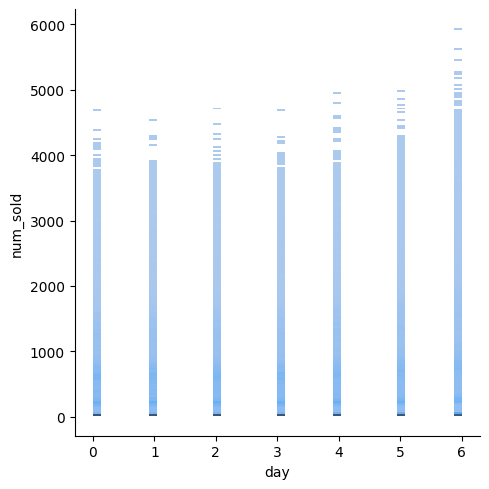

In [17]:
sns.displot(df, x="day", y="num_sold")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


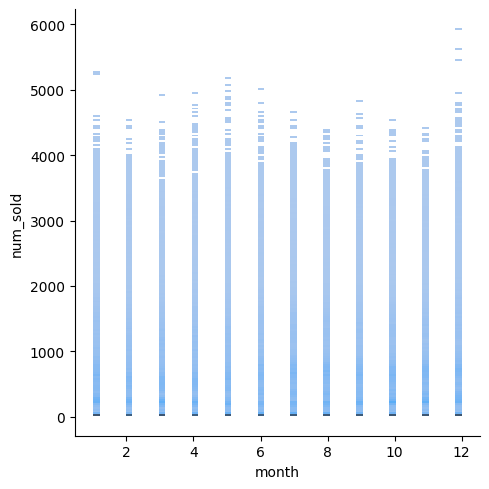

In [18]:
sns.displot(df, x="month", y="num_sold")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


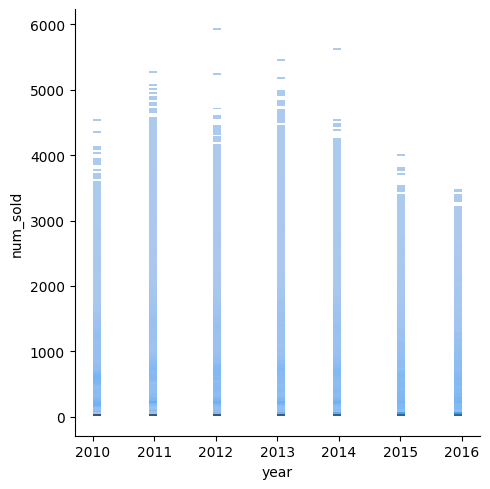

In [19]:
sns.displot(df, x="year", y="num_sold")

Visual Analysis shows that day, month and year all affect the number of sales. So let's edit `sticker_data_cleaned` to match.

In [20]:
sticker_data_cleaned['date'] = pd.to_datetime(sticker_data_cleaned['date'])
sticker_data_cleaned['year'] = sticker_data_cleaned['date'].dt.year
sticker_data_cleaned['month'] = sticker_data_cleaned['date'].dt.month_name()
sticker_data_cleaned['day'] = sticker_data_cleaned['date'].dt.day_name()

sticker_data_cleaned

,id,date,num_sold,Canada,Finland,Italy,Kenya,Norway,Singapore,Discount Stickers,Premium Sticker Mart,Stickers for Less,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode,year,month,day
1,1,2010-01-01,973.0,True,False,False,False,False,False,True,False,False,False,True,False,False,False,2010,January,Friday
2,2,2010-01-01,906.0,True,False,False,False,False,False,True,False,False,False,False,True,False,False,2010,January,Friday
3,3,2010-01-01,423.0,True,False,False,False,False,False,True,False,False,False,False,False,True,False,2010,January,Friday
4,4,2010-01-01,491.0,True,False,False,False,False,False,True,False,False,False,False,False,False,True,2010,January,Friday
5,5,2010-01-01,300.0,True,False,False,False,False,False,False,False,True,True,False,False,False,False,2010,January,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,2016-12-31,466.0,False,False,False,False,False,True,False,True,False,True,False,False,False,False,2016,December,Saturday
230126,230126,2016-12-31,2907.0,False,False,False,False,False,True,False,True,False,False,True,False,False,False,2016,December,Saturday
230127,230127,2016-12-31,2299.0,False,False,False,False,False,True,False,True,False,False,False,True,False,False,2016,December,Saturday
230128,230128,2016-12-31,1242.0,False,False,False,False,False,True,False,True,False,False,False,False,True,False,2016,December,Saturday


01 / 21 / 2024
Converting country 
Inspired by https://www.kaggle.com/competitions/playground-series-s5e1/discussion/556900

In [21]:
countries = pd.from_dummies(sticker_data_cleaned.loc[:, ['Canada', 'Finland', 'Italy', 'Norway', 'Kenya', 'Singapore']])
sticker_data_cleaned = sticker_data_cleaned.join(countries)
sticker_data_cleaned = sticker_data_cleaned.drop(columns=['Canada', 'Finland', 'Italy', 'Norway', 'Kenya', 'Singapore'])
sticker_data_cleaned

,id,date,num_sold,Discount Stickers,Premium Sticker Mart,Stickers for Less,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode,year,month,day,
1,1,2010-01-01,973.0,True,False,False,False,True,False,False,False,2010,January,Friday,Canada
2,2,2010-01-01,906.0,True,False,False,False,False,True,False,False,2010,January,Friday,Canada
3,3,2010-01-01,423.0,True,False,False,False,False,False,True,False,2010,January,Friday,Canada
4,4,2010-01-01,491.0,True,False,False,False,False,False,False,True,2010,January,Friday,Canada
5,5,2010-01-01,300.0,False,False,True,True,False,False,False,False,2010,January,Friday,Canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,2016-12-31,466.0,False,True,False,True,False,False,False,False,2016,December,Saturday,Singapore
230126,230126,2016-12-31,2907.0,False,True,False,False,True,False,False,False,2016,December,Saturday,Singapore
230127,230127,2016-12-31,2299.0,False,True,False,False,False,True,False,False,2016,December,Saturday,Singapore
230128,230128,2016-12-31,1242.0,False,True,False,False,False,False,True,False,2016,December,Saturday,Singapore


In [22]:
sticker_data_cleaned.columns

Index(['id', 'date', 'num_sold', 'Discount Stickers', 'Premium Sticker Mart',
       'Stickers for Less', 'Holographic Goose', 'Kaggle', 'Kaggle Tiers',
       'Kerneler', 'Kerneler Dark Mode', 'year', 'month', 'day', ''],
      dtype='object')

In [23]:
sticker_data_cleaned = sticker_data_cleaned.rename(columns={'': 'country'})
sticker_data_cleaned

,id,date,num_sold,Discount Stickers,Premium Sticker Mart,Stickers for Less,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode,year,month,day,country
1,1,2010-01-01,973.0,True,False,False,False,True,False,False,False,2010,January,Friday,Canada
2,2,2010-01-01,906.0,True,False,False,False,False,True,False,False,2010,January,Friday,Canada
3,3,2010-01-01,423.0,True,False,False,False,False,False,True,False,2010,January,Friday,Canada
4,4,2010-01-01,491.0,True,False,False,False,False,False,False,True,2010,January,Friday,Canada
5,5,2010-01-01,300.0,False,False,True,True,False,False,False,False,2010,January,Friday,Canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,2016-12-31,466.0,False,True,False,True,False,False,False,False,2016,December,Saturday,Singapore
230126,230126,2016-12-31,2907.0,False,True,False,False,True,False,False,False,2016,December,Saturday,Singapore
230127,230127,2016-12-31,2299.0,False,True,False,False,False,True,False,False,2016,December,Saturday,Singapore
230128,230128,2016-12-31,1242.0,False,True,False,False,False,False,True,False,2016,December,Saturday,Singapore


In [24]:
# Ordering by GDP per capita
gdppc = {'Canada': 55000,
            'Finland': 53000,
            'Italy': 35000,
            'Norway': 95000,
            'Kenya': 2100,
            'Singapore': 85000}

total = 0
for v in gdppc.values():
    total += v

for k, v in gdppc.items():
    gdppc[k] = v / total

print(gdppc)

sticker_data_cleaned['country'] = sticker_data_cleaned['country'].map(gdppc)
sticker_data_cleaned

{'Canada': 0.16917871424177175, 'Finland': 0.16302676099661642, 'Italy': 0.1076591817902184, 'Norway': 0.2922177791448785, 'Kenya': 0.0064595509074131035, 'Singapore': 0.2614580129191018}


,id,date,num_sold,Discount Stickers,Premium Sticker Mart,Stickers for Less,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode,year,month,day,country
1,1,2010-01-01,973.0,True,False,False,False,True,False,False,False,2010,January,Friday,0.169179
2,2,2010-01-01,906.0,True,False,False,False,False,True,False,False,2010,January,Friday,0.169179
3,3,2010-01-01,423.0,True,False,False,False,False,False,True,False,2010,January,Friday,0.169179
4,4,2010-01-01,491.0,True,False,False,False,False,False,False,True,2010,January,Friday,0.169179
5,5,2010-01-01,300.0,False,False,True,True,False,False,False,False,2010,January,Friday,0.169179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,2016-12-31,466.0,False,True,False,True,False,False,False,False,2016,December,Saturday,0.261458
230126,230126,2016-12-31,2907.0,False,True,False,False,True,False,False,False,2016,December,Saturday,0.261458
230127,230127,2016-12-31,2299.0,False,True,False,False,False,True,False,False,2016,December,Saturday,0.261458
230128,230128,2016-12-31,1242.0,False,True,False,False,False,False,True,False,2016,December,Saturday,0.261458


In [25]:
# sticker_data_cleaned = sticker_data_cleaned.join(pd.get_dummies(sticker_data_cleaned['year'].astype(str))).drop(columns='year')
sticker_data_cleaned = sticker_data_cleaned.join(pd.get_dummies(sticker_data_cleaned['month'])).drop(columns='month')
sticker_data_cleaned = sticker_data_cleaned.join(pd.get_dummies(sticker_data_cleaned['day'])).drop(columns='day')

sticker_data_cleaned

,id,date,num_sold,Discount Stickers,Premium Sticker Mart,Stickers for Less,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,...,November,October,September,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
1,1,2010-01-01,973.0,True,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
2,2,2010-01-01,906.0,True,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
3,3,2010-01-01,423.0,True,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
4,4,2010-01-01,491.0,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
5,5,2010-01-01,300.0,False,False,True,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,2016-12-31,466.0,False,True,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
230126,230126,2016-12-31,2907.0,False,True,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
230127,230127,2016-12-31,2299.0,False,True,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
230128,230128,2016-12-31,1242.0,False,True,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False


We now have our data cleaned and ready. Let's import relevant sklearn libraries and use our SGD Resgressor

In [26]:
y_train = sticker_data_cleaned['num_sold']
y_train

1          973.0
2          906.0
3          423.0
4          491.0
5          300.0
           ...  
230125     466.0
230126    2907.0
230127    2299.0
230128    1242.0
230129    1622.0
Name: num_sold, Length: 221259, dtype: float64

In [27]:
X_train = sticker_data_cleaned.drop(columns=['id', 'num_sold', 'date', 'year'])
X_train

,Discount Stickers,Premium Sticker Mart,Stickers for Less,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode,country,April,...,November,October,September,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
1,True,False,False,False,True,False,False,False,0.169179,False,...,False,False,False,True,False,False,False,False,False,False
2,True,False,False,False,False,True,False,False,0.169179,False,...,False,False,False,True,False,False,False,False,False,False
3,True,False,False,False,False,False,True,False,0.169179,False,...,False,False,False,True,False,False,False,False,False,False
4,True,False,False,False,False,False,False,True,0.169179,False,...,False,False,False,True,False,False,False,False,False,False
5,False,False,True,True,False,False,False,False,0.169179,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,False,True,False,True,False,False,False,False,0.261458,False,...,False,False,False,False,False,True,False,False,False,False
230126,False,True,False,False,True,False,False,False,0.261458,False,...,False,False,False,False,False,True,False,False,False,False
230127,False,True,False,False,False,True,False,False,0.261458,False,...,False,False,False,False,False,True,False,False,False,False
230128,False,True,False,False,False,False,True,False,0.261458,False,...,False,False,False,False,False,True,False,False,False,False


In [28]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_percentage_error

# Using all defaults of the SGDRegressor class
sgd_regressor = SGDRegressor()
sgd_regressor.fit(X_train, y_train)

SGDRegressor()

Now that we have our regressor let's clean X_test to match X_train

In [29]:
X_test = pd.read_csv('/kaggle/input/forecasting-sticker-sales/test.csv')
X_test = X_test.drop(columns='id')
X_test = X_test.join(pd.get_dummies(X_test['store'])).drop(columns='store')
X_test = X_test.join(pd.get_dummies(X_test['product'])).drop(columns='product')

X_test['date'] = pd.to_datetime(X_test['date'])
X_test['year'] = X_test['date'].dt.year
X_test['month'] = X_test['date'].dt.month_name()
X_test['day'] = X_test['date'].dt.day_name()
X_test = X_test.drop(columns=['date', 'year'])

# Ordering by GDP per capita
gdppc = {'Canada': 55000,
            'Finland': 53000,
            'Italy': 35000,
            'Norway': 95000,
            'Kenya': 2100,
            'Singapore': 85000}

total = 0
for v in gdppc.values():
    total += v

for k, v in gdppc.items():
    gdppc[k] = v / total

print(gdppc)

X_test['country'] = X_test['country'].map(gdppc)

X_test = X_test.join(pd.get_dummies(X_test['month'])).drop(columns='month')
X_test = X_test.join(pd.get_dummies(X_test['day'])).drop(columns='day')

print(X_test.columns)

X_test

{'Canada': 0.16917871424177175, 'Finland': 0.16302676099661642, 'Italy': 0.1076591817902184, 'Norway': 0.2922177791448785, 'Kenya': 0.0064595509074131035, 'Singapore': 0.2614580129191018}
Index(['country', 'Discount Stickers', 'Premium Sticker Mart',
       'Stickers for Less', 'Holographic Goose', 'Kaggle', 'Kaggle Tiers',
       'Kerneler', 'Kerneler Dark Mode', 'April', 'August', 'December',
       'February', 'January', 'July', 'June', 'March', 'May', 'November',
       'October', 'September', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')


,country,Discount Stickers,Premium Sticker Mart,Stickers for Less,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode,April,...,November,October,September,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0.169179,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,0.169179,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,0.169179,True,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0.169179,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
4,0.169179,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98545,0.261458,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
98546,0.261458,False,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
98547,0.261458,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
98548,0.261458,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False


In [30]:
# Make sure the code in the next cell will work
set(X_test.columns) - set(X_train.columns)
X_train.columns

Index(['Discount Stickers', 'Premium Sticker Mart', 'Stickers for Less',
       'Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler',
       'Kerneler Dark Mode', 'country', 'April', 'August', 'December',
       'February', 'January', 'July', 'June', 'March', 'May', 'November',
       'October', 'September', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')

In [31]:
cols = ['Discount Stickers', 'Premium Sticker Mart', 'Stickers for Less',
       'Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler',
       'Kerneler Dark Mode','country', 'April', 'August', 'December',
       'February', 'January', 'July', 'June', 'March', 'May', 'November',
       'October', 'September', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday']

X_test = X_test.reindex(columns=cols)
X_test

,Discount Stickers,Premium Sticker Mart,Stickers for Less,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode,country,April,...,November,October,September,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,True,False,False,True,False,False,False,False,0.169179,False,...,False,False,False,False,False,False,True,False,False,False
1,True,False,False,False,True,False,False,False,0.169179,False,...,False,False,False,False,False,False,True,False,False,False
2,True,False,False,False,False,True,False,False,0.169179,False,...,False,False,False,False,False,False,True,False,False,False
3,True,False,False,False,False,False,True,False,0.169179,False,...,False,False,False,False,False,False,True,False,False,False
4,True,False,False,False,False,False,False,True,0.169179,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98545,False,True,False,True,False,False,False,False,0.261458,False,...,False,False,False,False,False,False,False,False,True,False
98546,False,True,False,False,True,False,False,False,0.261458,False,...,False,False,False,False,False,False,False,False,True,False
98547,False,True,False,False,False,True,False,False,0.261458,False,...,False,False,False,False,False,False,False,False,True,False
98548,False,True,False,False,False,False,True,False,0.261458,False,...,False,False,False,False,False,False,False,False,True,False


In [32]:
for a, b in zip(list(X_test.columns), list(X_train.columns)):
    if a != b:
        print(a + " " + b)

We've cleaned X_test, now let's use our sgd_regressor

In [33]:
y_pred = sgd_regressor.predict(X_test)

Now that we have our predictions, let's create our csv to send submit.

In [34]:
X_test = pd.read_csv('/kaggle/input/forecasting-sticker-sales/test.csv')
X_test

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode
...,...,...,...,...,...
98545,328675,2019-12-31,Singapore,Premium Sticker Mart,Holographic Goose
98546,328676,2019-12-31,Singapore,Premium Sticker Mart,Kaggle
98547,328677,2019-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers
98548,328678,2019-12-31,Singapore,Premium Sticker Mart,Kerneler


In [35]:
X_test = X_test['id']
X_test

0        230130
1        230131
2        230132
3        230133
4        230134
          ...  
98545    328675
98546    328676
98547    328677
98548    328678
98549    328679
Name: id, Length: 98550, dtype: int64

In [36]:
y_pred = pd.DataFrame(y_pred)
y_pred

,0
0,-117.767939
1,1048.380721
2,833.870829
3,367.999871
4,460.915716
...,...
98545,738.685464
98546,1904.834123
98547,1690.324231
98548,1224.453273


In [37]:
df = pd.DataFrame(X_test).join(y_pred)
df

,id,0
0,230130,-117.767939
1,230131,1048.380721
2,230132,833.870829
3,230133,367.999871
4,230134,460.915716
...,...,...
98545,328675,738.685464
98546,328676,1904.834123
98547,328677,1690.324231
98548,328678,1224.453273


In [38]:
df.rename(columns={0 : 'num_sold'}, inplace=True)
df

,id,num_sold
0,230130,-117.767939
1,230131,1048.380721
2,230132,833.870829
3,230133,367.999871
4,230134,460.915716
...,...,...
98545,328675,738.685464
98546,328676,1904.834123
98547,328677,1690.324231
98548,328678,1224.453273


In [39]:
#updated to match second entry into competition
df.to_csv('/kaggle/working/sticker_submission2.csv', index=False)